In [1]:
import re
import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

Want to optimize this function.

In [16]:
def generate_classical_shadow_OLD(circuit, shadow_size):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/.
    Given a quantum circuit, this function creates a collection of bit-strings generated by random single-qubit Pauli measurements and records the associated random pauli measurement.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
    """

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Generate the measurement scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_schemes = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    start_time = time.time()

    # 
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_schemes[i][j] == 0:
                qc.h(j)
            elif measurement_schemes[i][j] == 1:
                qc.s(j)
                qc.h(j)
            else:
                continue

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # A change

        # Store the bit-strings representing the measured basis states. Because the sampler is configured to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bit-string.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements as the eigen values of the observable.
        for j in range(num_qubits):
            measurements[i][j] = 1 if states[j] == '0' else -1

    print("Time taken to generate classical shadow: ", time.time() - start_time)

    return measurements, measurement_schemes

In [34]:
def generate_classical_shadow_NEW(circuit, shadow_size):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/.
    Given a quantum circuit, this function creates a collection of bit-strings generated by random single-qubit Pauli measurements and records the associated random pauli measurement.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
    """

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Generate the measurement scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_schemes = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # List to store the circuits for each measurement scheme.
    circuits = []

    start = time.time()

    start_time = time.time()

    # Generate the circuits for each measurement scheme.
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_schemes[i][j] == 0:
                qc.h(j)
            elif measurement_schemes[i][j] == 1:
                qc.s(j)
                qc.h(j)
            else:
                continue

        qc.measure_all()

        circuits.append(qc)

    print("Circuit generation took {} seconds.".format(time.time() - start_time))
    print("That is {} seconds per circuit.".format((time.time() - start_time) / shadow_size))

    start_time = time.time()

    # Simulate the circuits and store the results.

    # Run the sampler on the quantum circuit and store the result.
    results = sampler.run(circuits).result()

    print("Simulation took {} seconds.".format(time.time() - start_time))
    print("That is {} seconds per circuit.".format((time.time() - start_time) / shadow_size))

    start_time = time.time()

    for i, result in enumerate(results):

        # Store the bit-strings representing the measured basis states. Because the sampler is configured to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bit-string.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements as the eigen values of the observable.
        for j in range(num_qubits):
            measurements[i][j] = 1 if states[j] == '0' else -1

    print("Processing took {} seconds.".format(time.time() - start_time))
    print("That is {} seconds per circuit.".format((time.time() - start_time) / shadow_size))

    print("Total time taken to generate classical shadow: ", time.time() - start)

    return measurements, measurement_schemes

Test the running time with a bell state.

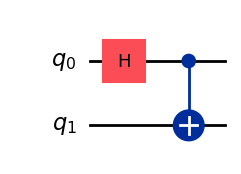

In [18]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [35]:
shadow = generate_classical_shadow_NEW(bell_state_qc, 10000)

Circuit generation took 1.606412410736084 seconds.
That is 0.0001606412410736084 seconds per circuit.
Simulation took 10.113117933273315 seconds.
That is 0.0010113117933273315 seconds per circuit.
Processing took 0.04600024223327637 seconds.
That is 4.600024223327637e-06 seconds per circuit.
Total time taken to generate classical shadow:  11.765530586242676


In [31]:
shadow = generate_classical_shadow_OLD(bell_state_qc, 10000)

Time taken to generate classical shadow:  18.55329704284668
